In [1]:
import numpy as np
import pandas as pd
import glob
import sys
import os
import gc
import open3d as o3d

from shapely.ops import cascaded_union, polygonize
from shapely.geometry import Polygon, LineString
import shapely.geometry as geometry

from scipy import optimize
from scipy.spatial import ConvexHull, convex_hull_plot_2d, Delaunay
import scipy.io as sio

from matplotlib import pyplot as plt
from matplotlib import rc
from mpl_toolkits.mplot3d import Axes3D

import math
from math import pi

from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.cluster import KMeans

from descartes import PolygonPatch

In [2]:
# Read in csvs with data produced from CloudDBH file
wytham_ss_dbh_path = '/Users/snix/Documents/2021-2023/UCL/Dissertation/Results/wytham_ss_dbh.csv'
wytham_ms_dbh_path = '/Users/snix/Documents/2021-2023/UCL/Dissertation/Results/wytham_ms_dbh.csv'
trop_dbh_path = '/Users/snix/Documents/2021-2023/UCL/Dissertation/Results/trop_dbh.csv'

# Read in QSM summary files for Wytham Woods + Tropical Datasets
wytham_qsm_path = "/Users/snix/Documents/2021-2023/UCL/Dissertation/Calders Et Al/analysis_and_figures/trees_summary.csv"
trop_qsm_path = '/Users/snix/Documents/2021-2023/UCL/Dissertation/MLA01_man.csv'


In [ ]:
# Clean and organize Wytham data for modelling.
wytham_qsm = pd.read_csv(wytham_qsm_path)
wytham_qsm = wytham_qsm[['TLS_ID','stemlocx_[m]', 'stemlocy_[m]', 
                         'DBH_TLS_[m]','Hgt_pts_[m]', 
                         'VerticalCrownProjectedArea_pts_[m2]', 
                         'Vol_QSM_avg_[m3]','Vol_QSM_D0_25mm_avg_[m3]', 
                         'Vol_QSM_D25_50mm_avg_[m3]', 'Vol_QSM_D50_75mm_avg_[m3]',
                         'Vol_QSM_D75_100mm_avg_[m3]', 'Vol_QSM_D100_200mm_avg_[m3]', 
                         'Vol_QSM_D200_500mm_avg_[m3]','Vol_QSM_D500_1000mm_avg_[m3]', 
                         'Vol_QSM_D1000mm_avg_[m3]']]
wytham_qsm['TLS_ID'] = wytham_qsm['TLS_ID'].astype(str)

# Make Wytham DBH dataset 
wytham_ss_dbh = pd.read_csv(wytham_ss_dbh_path, index_col = [0])
wytham_ss_dbh['TLS_ID'] = wytham_ss_dbh['TLS_ID'].astype(str)

wytham_ms_dbh = pd.read_csv(wytham_ms_dbh_path, index_col = [0])
wytham_ms_dbh['TLS_ID'] = wytham_ms_dbh['TLS_ID'].astype(str)

# Multi-stems have to be at least 10cm DBH.
wytham_ms_dbh = wytham_ms_dbh[wytham_ms_dbh['dbhadj'] > 0.1]

# Concatenate single + multi-stems to get full Wytham dataset.
wytham_dbh = pd.concat([wytham_ss_dbh, wytham_ms_dbh])

# Set aside flagged trees to see if models can estimate later.
wytham_flagged = wytham_dbh[wytham_dbh['Flagged']==1]

# Merge DBH and QSM datasets for modelling.
wytham = wytham_dbh.merge(wytham_qsm, on ='TLS_ID').dropna(axis=0)


In [3]:
# Clean and organize tropical data for modelling.
trop_qsm = pd.read_csv(trop_qsm_path)
trop_qsm['TLS_ID'] = trop_qsm['tree'].str[11:]
trop_qsm = trop_qsm.drop(['tree', 'x_m', 'y_m'], axis='columns')

# Make tropical DBH dataset
trop_dbh = pd.read_csv(trop_dbh_path, index_col = [0])
trop_dbh['TLS_ID'] = trop_dbh['TLS_ID'].astype(str)

# Set aside flagged trees to see if models can estimate later.
trop_flagged = trop_dbh[trop_dbh['Flagged']==1]

# Merge DBH and QSM for modelling.
tropical = trop_dbh.merge(trop_qsm, on ='TLS_ID').dropna(axis=0)


In [4]:
# Set font for plotting.
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=False)

Text(0, 0.5, 'DBH from TLS')

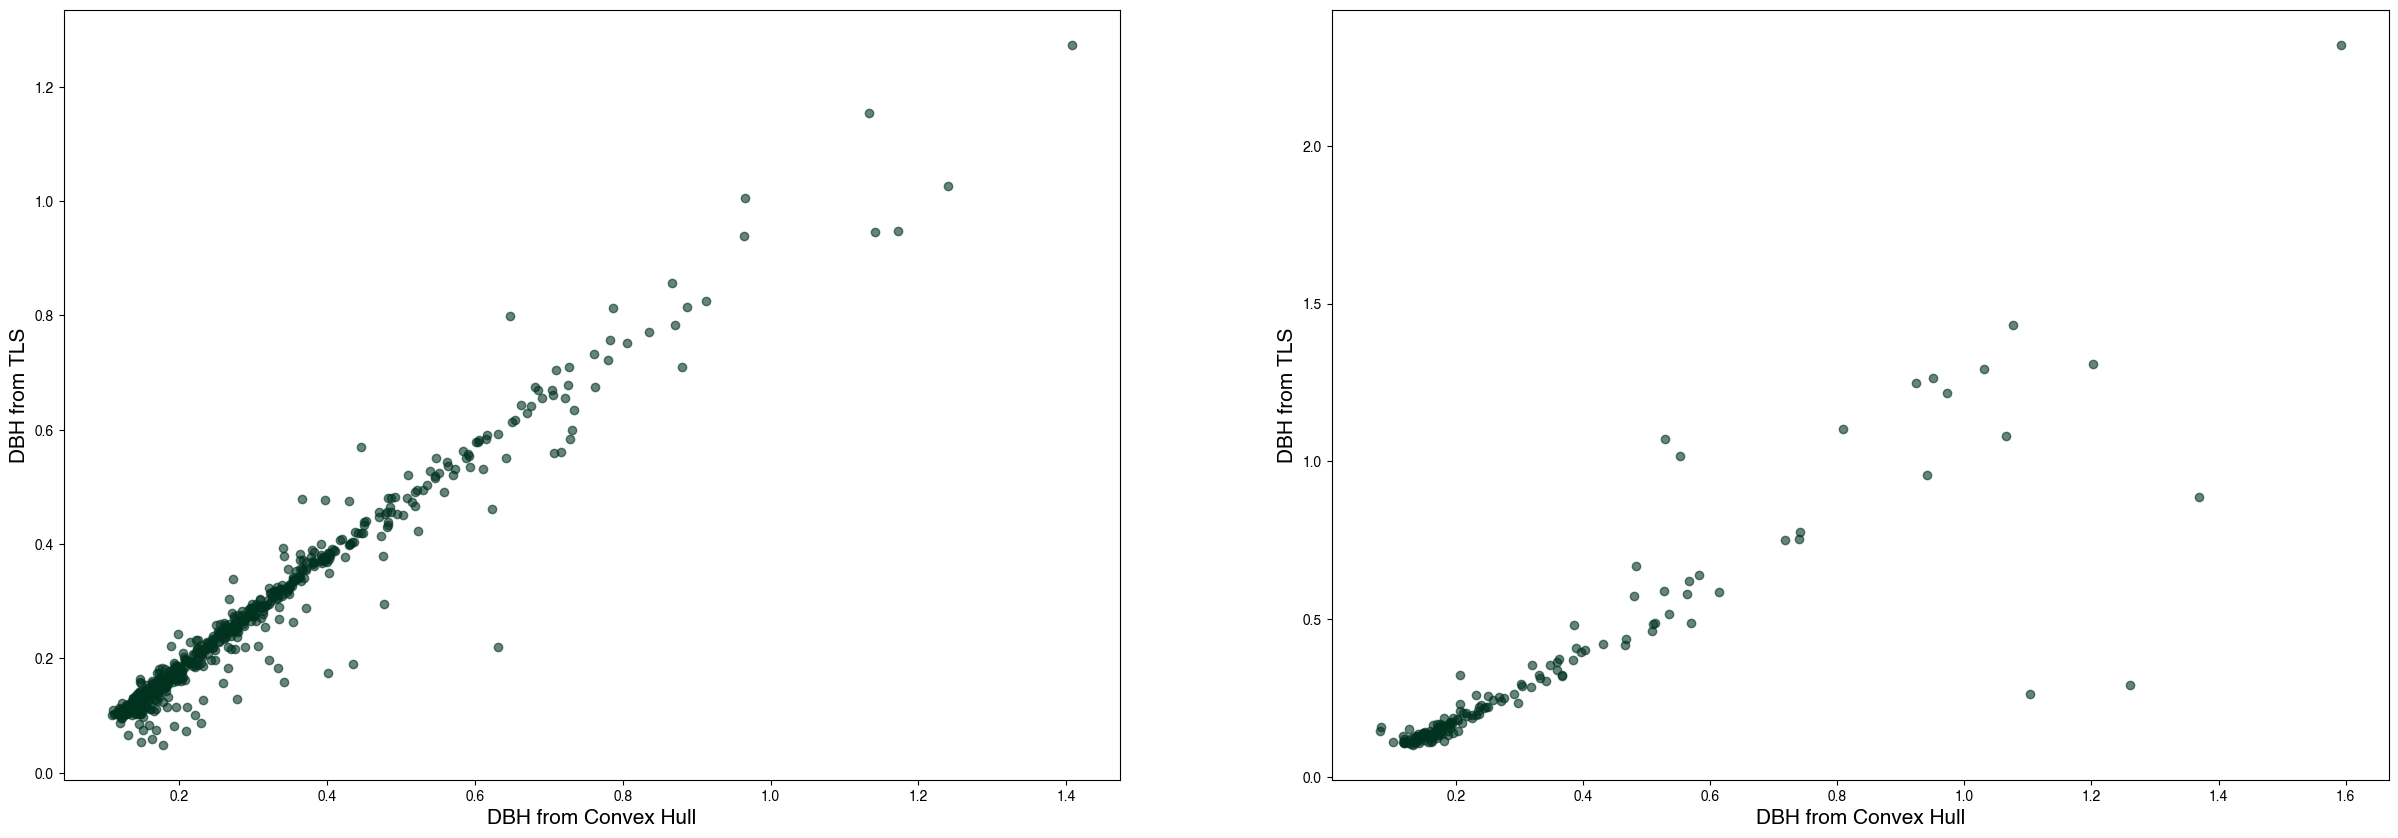

In [5]:
# Plot TLS DBH vs. 'field DBH' calculated from convex hull 
fig, axs = plt.subplots(1, 2, figsize=(30,10))

# Wytham Woods:
axs[0].scatter(wytham['dbhadj'], wytham['DBH_TLS_[m]'], color='#013220', alpha=0.6)
axs[0].set_xlabel('DBH from Convex Hull', fontsize=15)
axs[0].set_ylabel('DBH from TLS', fontsize=15)

# Tropical:
axs[1].scatter(tropical['dbhadj'], tropical['DBHqsm'], color='#013220', alpha=0.6)
axs[1].set_xlabel('DBH from Convex Hull', fontsize=15)
axs[1].set_ylabel('DBH from TLS', fontsize=15)


In [6]:
# Drop flagged trees from dataset before modelling
print(f'length of wytham before {len(wytham)}')
wytham  = wytham[wytham['Flagged']==0]
print(f'length of wytham after {len(wytham)}')

print(f'length of tropical before {len(tropical)}')
tropical  = tropical[tropical['Flagged']==0]
print(f'length of tropical after {len(tropical)}')

length of wytham before 597
length of wytham after 584
length of tropical before 163
length of tropical after 157


In [7]:
# Set up labels and features for random forest 
# Random forest code based on:
# https://towardsdatascience.com/random-forest-in-python-24d0893d51c0

# Set labels (values we want the model to predict).
labels_wytham = np.array(wytham['dbhadj'])
labels_tropical = np.array(tropical['dbhadj'])

# Remove the labels (and other DBH columns) from the features.
features_wytham = wytham.drop(['TLS_ID','dbhadj', 'dbh13', 'DBH_TLS_[m]', 'dbhcirc'], axis = 1)
features_tropical = tropical.drop(['TLS_ID','dbhadj', 'dbh13', 'DBHqsm', 'DBHcyl', 'dbhcirc'], axis = 1)

# Save feature names in a list for later.
featurelist_wytham = list(features_wytham.columns)
featurelist_tropical = list(features_tropical.columns)

# Convert features to numpy array.
features_wytham = np.array(features_wytham)
features_tropical = np.array(features_tropical)

In [ ]:
def set_up_RF (treedata):
    """Returns labels, features, featurelist"""
    
    # Set labels (values we want models to predict)
    labels = np.array(treedata['dbhadj'])
    
    # Depending on dataset, remove labels (and other DBH columns) from features.
    if treedata == wytham:
        features = treedata.drop(['TLS_ID','dbhadj', 'dbh13', 'DBH_TLS_[m]', 'dbhcirc'], axis = 1)
    else if treedata == tropical:
        features = treedata.drop(['TLS_ID','dbhadj', 'dbh13', 'DBHqsm', 'DBHcyl', 'dbhcirc'], axis = 1)
    
    # Save feature names in a list for later
    featurelist = list(features.columns)
    
    # Convert features to numpy array.
    features = np.array(features)
    
    return labels, features, featurelist

In [8]:
# Set up hyperparameter grids to tune within. 

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]

# Number of features to consider at every split
max_features = [1, 2, 4, 6, 8, 10, 12, 14, 16]

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 3, 4, 5, 6, 7, 8, 9, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 3, 4, 5]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': [1, 2, 4, 6, 8, 10, 12, 14, 16], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 10], 'min_samples_leaf': [1, 2, 3, 4, 5], 'bootstrap': [True, False]}


In [ ]:
def tune_grid(features, labels, random_grid, verbose=False):
    """
    Code in this function is based on 
    https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74
    
    """
    # Split training and testing.
    train_features, test_features, train_labels, test_labels = train_test_split(features, labels, train_size = 0.60, random_state = 42)
    
    if verbose:
        print('Training Features Shape:', w_train_features.shape)
        print('Training Labels Shape:', w_train_labels.shape)
        print('Testing Features Shape:', w_test_features.shape)
        print('Testing Labels Shape:', w_test_labels.shape)
    
    
    #
    
    

In [9]:
# Using Skicit-learn to split data into training and testing sets

# Split the data into training and testing sets
w_train_features, w_test_features, w_train_labels, w_test_labels = train_test_split(features_wytham, labels_wytham, train_size = 0.60, random_state = 42)

print('Training Features Shape:', w_train_features.shape)
print('Training Labels Shape:', w_train_labels.shape)
print('Testing Features Shape:', w_test_features.shape)
print('Testing Labels Shape:', w_test_labels.shape)

# Use the random grid to search for best hyperparameters
# First create the base model to tune
wytham_rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
wytham_rf_random = RandomizedSearchCV(estimator = wytham_rf, param_distributions = random_grid, n_iter = 300, cv = 4, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
wytham_rf_random.fit(w_train_features, w_train_labels)

# Uncomment to look at best hyperparameters
#rf_random.best_params_ 

#https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy, predictions, errors

# Get best model without hyperparameter tuning
wytham_model = RandomForestRegressor(n_estimators = 1000, random_state = 42)
wytham_model.fit(w_train_features, w_train_labels)
wytham_base_accuracy, wytham_base_predictions, wytham_base_errors = evaluate(wytham_model, w_test_features, w_test_labels)

# Get best model with hyperparameter tuning
wytham_best_random = wytham_rf_random.best_estimator_
wytham_random_accuracy, wytham_random_predictions, wytham_random_errors = evaluate(wytham_best_random, w_test_features, w_test_labels)

print('Improvement of {:0.2f}%.'.format( 100 * (wytham_random_accuracy - wytham_base_accuracy) / wytham_base_accuracy))

Training Features Shape: (350, 20)
Training Labels Shape: (350,)
Testing Features Shape: (234, 20)
Testing Labels Shape: (234,)
Fitting 4 folds for each of 300 candidates, totalling 1200 fits
Model Performance
Average Error: 0.0250 degrees.
Accuracy = 93.63%.
Model Performance
Average Error: 0.0255 degrees.
Accuracy = 93.30%.
Improvement of -0.35%.


In [10]:
# Get numerical feature importances
wytham_importances = list(wytham_best_random.feature_importances_)
# List of tuples with variable and importance
wytham_feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(featurelist_wytham, wytham_importances)]
# Sort the feature importances by most important first
wytham_feature_importances = sorted(wytham_feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in wytham_feature_importances];


Variable: Vol_QSM_D500_1000mm_avg_[m3] Importance: 0.46
Variable: Vol_QSM_avg_[m3]     Importance: 0.3
Variable: Vol_QSM_D200_500mm_avg_[m3] Importance: 0.12
Variable: Vol_QSM_D75_100mm_avg_[m3] Importance: 0.03
Variable: maxdistadj           Importance: 0.02
Variable: Vol_QSM_D1000mm_avg_[m3] Importance: 0.02
Variable: avgresid             Importance: 0.01
Variable: Vol_QSM_D50_75mm_avg_[m3] Importance: 0.01
Variable: Vol_QSM_D100_200mm_avg_[m3] Importance: 0.01
Variable: dbh_hgt              Importance: 0.0
Variable: stems                Importance: 0.0
Variable: maxdist13            Importance: 0.0
Variable: Flagged              Importance: 0.0
Variable: resid_norm           Importance: 0.0
Variable: stemlocx_[m]         Importance: 0.0
Variable: stemlocy_[m]         Importance: 0.0
Variable: Hgt_pts_[m]          Importance: 0.0
Variable: VerticalCrownProjectedArea_pts_[m2] Importance: 0.0
Variable: Vol_QSM_D0_25mm_avg_[m3] Importance: 0.0
Variable: Vol_QSM_D25_50mm_avg_[m3] Importa

In [11]:
# Using Skicit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor


# Split the data into training and testing sets
t_train_features, t_test_features, t_train_labels, t_test_labels = train_test_split(features_tropical, labels_tropical, train_size = 0.60, random_state = 42)

print('Training Features Shape:', t_train_features.shape)
print('Training Labels Shape:', t_train_labels.shape)
print('Testing Features Shape:', t_test_features.shape)
print('Testing Labels Shape:', t_test_labels.shape)

# Use the random grid to search for best hyperparameters
# First create the base model to tune
tropical_rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
tropical_rf_random = RandomizedSearchCV(estimator = tropical_rf, param_distributions = random_grid, n_iter = 300, cv = 4, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
tropical_rf_random.fit(t_train_features, t_train_labels)

# Uncomment to look at best hyperparameters
#rf_random.best_params_ 

#https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74

def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy, predictions, errors

# Get best model without hyperparameter tuning
tropical_model = RandomForestRegressor(n_estimators = 1000, random_state = 42)
tropical_model.fit(t_train_features, t_train_labels)
tropical_base_accuracy, tropical_base_predictions, tropical_base_errors = evaluate(tropical_model, t_test_features, t_test_labels)

# Get best model with hyperparameter tuning
tropical_best_random = tropical_rf_random.best_estimator_
tropical_random_accuracy, tropical_random_predictions, tropical_random_errors = evaluate(tropical_best_random, t_test_features, t_test_labels)

print('Improvement of {:0.2f}%.'.format( 100 * (tropical_random_accuracy - tropical_base_accuracy) / tropical_base_accuracy))


Training Features Shape: (94, 34)
Training Labels Shape: (94,)
Testing Features Shape: (63, 34)
Testing Labels Shape: (63,)
Fitting 4 folds for each of 300 candidates, totalling 1200 fits
[CV] END bootstrap=True, max_depth=40, max_features=16, min_samples_leaf=1, min_samples_split=6, n_estimators=1200; total time=   1.4s
[CV] END bootstrap=False, max_depth=100, max_features=10, min_samples_leaf=3, min_samples_split=3, n_estimators=1800; total time=   1.9s
[CV] END bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=2, min_samples_split=7, n_estimators=200; total time=   0.1s
[CV] END bootstrap=True, max_depth=10, max_features=2, min_samples_leaf=4, min_samples_split=6, n_estimators=2000; total time=   1.3s
[CV] END bootstrap=False, max_depth=50, max_features=1, min_samples_leaf=2, min_samples_split=5, n_estimators=1200; total time=   0.6s
[CV] END bootstrap=False, max_depth=20, max_features=4, min_samples_leaf=2, min_samples_split=8, n_estimators=1600; total time=   1.1s
[C

[CV] END bootstrap=True, max_depth=10, max_features=2, min_samples_leaf=5, min_samples_split=7, n_estimators=200; total time=   0.1s
[CV] END bootstrap=False, max_depth=20, max_features=8, min_samples_leaf=5, min_samples_split=9, n_estimators=1400; total time=   1.2s
[CV] END bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=4, n_estimators=1000; total time=   0.6s
[CV] END bootstrap=True, max_depth=110, max_features=16, min_samples_leaf=1, min_samples_split=5, n_estimators=400; total time=   0.5s
[CV] END bootstrap=False, max_depth=30, max_features=14, min_samples_leaf=5, min_samples_split=7, n_estimators=800; total time=   0.9s
[CV] END bootstrap=False, max_depth=50, max_features=10, min_samples_leaf=2, min_samples_split=10, n_estimators=400; total time=   0.4s
[CV] END bootstrap=False, max_depth=40, max_features=8, min_samples_leaf=5, min_samples_split=6, n_estimators=1200; total time=   1.0s
[CV] END bootstrap=False, max_depth=50, max_features=14,

[CV] END bootstrap=True, max_depth=50, max_features=8, min_samples_leaf=2, min_samples_split=7, n_estimators=400; total time=   0.4s
[CV] END bootstrap=False, max_depth=80, max_features=14, min_samples_leaf=3, min_samples_split=9, n_estimators=1400; total time=   1.8s
[CV] END bootstrap=False, max_depth=20, max_features=14, min_samples_leaf=1, min_samples_split=4, n_estimators=200; total time=   0.3s
[CV] END bootstrap=False, max_depth=40, max_features=8, min_samples_leaf=1, min_samples_split=9, n_estimators=800; total time=   0.8s
[CV] END bootstrap=False, max_depth=70, max_features=10, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   0.2s
[CV] END bootstrap=True, max_depth=60, max_features=8, min_samples_leaf=3, min_samples_split=8, n_estimators=2000; total time=   1.7s
[CV] END bootstrap=False, max_depth=10, max_features=2, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   0.1s
[CV] END bootstrap=True, max_depth=10, max_features=10, min

[CV] END bootstrap=True, max_depth=10, max_features=2, min_samples_leaf=5, min_samples_split=7, n_estimators=200; total time=   0.1s
[CV] END bootstrap=False, max_depth=20, max_features=8, min_samples_leaf=5, min_samples_split=9, n_estimators=1400; total time=   1.2s
[CV] END bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=4, n_estimators=1000; total time=   0.6s
[CV] END bootstrap=True, max_depth=110, max_features=16, min_samples_leaf=1, min_samples_split=5, n_estimators=400; total time=   0.5s
[CV] END bootstrap=False, max_depth=30, max_features=14, min_samples_leaf=5, min_samples_split=7, n_estimators=800; total time=   1.0s
[CV] END bootstrap=False, max_depth=50, max_features=1, min_samples_leaf=1, min_samples_split=4, n_estimators=200; total time=   0.1s
[CV] END bootstrap=False, max_depth=30, max_features=12, min_samples_leaf=4, min_samples_split=8, n_estimators=1200; total time=   1.4s
[CV] END bootstrap=True, max_depth=20, max_features=4, mi

[CV] END bootstrap=True, max_depth=40, max_features=16, min_samples_leaf=1, min_samples_split=6, n_estimators=1200; total time=   1.4s
[CV] END bootstrap=False, max_depth=100, max_features=10, min_samples_leaf=3, min_samples_split=3, n_estimators=1800; total time=   1.9s
[CV] END bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=2, min_samples_split=7, n_estimators=200; total time=   0.1s
[CV] END bootstrap=False, max_depth=50, max_features=10, min_samples_leaf=2, min_samples_split=10, n_estimators=400; total time=   0.4s
[CV] END bootstrap=False, max_depth=40, max_features=8, min_samples_leaf=5, min_samples_split=6, n_estimators=1200; total time=   1.0s
[CV] END bootstrap=False, max_depth=50, max_features=14, min_samples_leaf=1, min_samples_split=3, n_estimators=2000; total time=   3.0s
[CV] END bootstrap=False, max_depth=90, max_features=14, min_samples_leaf=4, min_samples_split=7, n_estimators=1800; total time=   2.2s
[CV] END bootstrap=False, max_depth=90, max_feature

[CV] END bootstrap=False, max_depth=70, max_features=16, min_samples_leaf=4, min_samples_split=7, n_estimators=200; total time=   0.3s
[CV] END bootstrap=True, max_depth=20, max_features=8, min_samples_leaf=5, min_samples_split=7, n_estimators=1200; total time=   1.0s
[CV] END bootstrap=False, max_depth=90, max_features=6, min_samples_leaf=1, min_samples_split=5, n_estimators=1400; total time=   1.3s
[CV] END bootstrap=True, max_depth=40, max_features=16, min_samples_leaf=4, min_samples_split=2, n_estimators=800; total time=   0.9s
[CV] END bootstrap=False, max_depth=50, max_features=1, min_samples_leaf=1, min_samples_split=4, n_estimators=200; total time=   0.1s
[CV] END bootstrap=False, max_depth=30, max_features=12, min_samples_leaf=4, min_samples_split=8, n_estimators=1200; total time=   1.3s
[CV] END bootstrap=True, max_depth=20, max_features=4, min_samples_leaf=5, min_samples_split=2, n_estimators=400; total time=   0.3s
[CV] END bootstrap=False, max_depth=90, max_features=8, min

[CV] END bootstrap=True, max_depth=10, max_features=2, min_samples_leaf=5, min_samples_split=7, n_estimators=200; total time=   0.1s
[CV] END bootstrap=False, max_depth=20, max_features=8, min_samples_leaf=5, min_samples_split=9, n_estimators=1400; total time=   1.2s
[CV] END bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=4, n_estimators=1000; total time=   0.7s
[CV] END bootstrap=True, max_depth=110, max_features=16, min_samples_leaf=1, min_samples_split=5, n_estimators=400; total time=   0.5s
[CV] END bootstrap=False, max_depth=30, max_features=14, min_samples_leaf=5, min_samples_split=7, n_estimators=800; total time=   1.0s
[CV] END bootstrap=True, max_depth=10, max_features=2, min_samples_leaf=4, min_samples_split=6, n_estimators=2000; total time=   1.2s
[CV] END bootstrap=False, max_depth=50, max_features=1, min_samples_leaf=2, min_samples_split=5, n_estimators=1200; total time=   0.6s
[CV] END bootstrap=False, max_depth=20, max_features=4, mi

[CV] END bootstrap=False, max_depth=70, max_features=16, min_samples_leaf=4, min_samples_split=7, n_estimators=200; total time=   0.3s
[CV] END bootstrap=True, max_depth=20, max_features=8, min_samples_leaf=5, min_samples_split=7, n_estimators=1200; total time=   1.0s
[CV] END bootstrap=False, max_depth=90, max_features=6, min_samples_leaf=1, min_samples_split=5, n_estimators=1400; total time=   1.3s
[CV] END bootstrap=True, max_depth=40, max_features=16, min_samples_leaf=4, min_samples_split=2, n_estimators=800; total time=   0.9s
[CV] END bootstrap=False, max_depth=50, max_features=1, min_samples_leaf=1, min_samples_split=4, n_estimators=200; total time=   0.1s
[CV] END bootstrap=False, max_depth=30, max_features=12, min_samples_leaf=4, min_samples_split=8, n_estimators=1200; total time=   1.3s
[CV] END bootstrap=True, max_depth=20, max_features=4, min_samples_leaf=5, min_samples_split=2, n_estimators=400; total time=   0.3s
[CV] END bootstrap=False, max_depth=90, max_features=8, min

[CV] END bootstrap=True, max_depth=40, max_features=16, min_samples_leaf=1, min_samples_split=6, n_estimators=1200; total time=   1.4s
[CV] END bootstrap=False, max_depth=100, max_features=10, min_samples_leaf=3, min_samples_split=3, n_estimators=1800; total time=   1.9s
[CV] END bootstrap=True, max_depth=110, max_features=2, min_samples_leaf=2, min_samples_split=7, n_estimators=200; total time=   0.1s
[CV] END bootstrap=False, max_depth=50, max_features=1, min_samples_leaf=1, min_samples_split=4, n_estimators=200; total time=   0.1s
[CV] END bootstrap=False, max_depth=30, max_features=12, min_samples_leaf=4, min_samples_split=8, n_estimators=1200; total time=   1.3s
[CV] END bootstrap=False, max_depth=50, max_features=14, min_samples_leaf=1, min_samples_split=3, n_estimators=2000; total time=   3.0s
[CV] END bootstrap=False, max_depth=90, max_features=14, min_samples_leaf=4, min_samples_split=7, n_estimators=1800; total time=   2.2s
[CV] END bootstrap=False, max_depth=90, max_features

[CV] END bootstrap=True, max_depth=10, max_features=2, min_samples_leaf=5, min_samples_split=7, n_estimators=200; total time=   0.1s
[CV] END bootstrap=False, max_depth=20, max_features=8, min_samples_leaf=5, min_samples_split=9, n_estimators=1400; total time=   1.2s
[CV] END bootstrap=True, max_depth=100, max_features=2, min_samples_leaf=4, min_samples_split=4, n_estimators=1000; total time=   0.6s
[CV] END bootstrap=True, max_depth=110, max_features=16, min_samples_leaf=1, min_samples_split=5, n_estimators=400; total time=   0.5s
[CV] END bootstrap=False, max_depth=30, max_features=14, min_samples_leaf=5, min_samples_split=7, n_estimators=800; total time=   1.0s
[CV] END bootstrap=True, max_depth=10, max_features=2, min_samples_leaf=4, min_samples_split=6, n_estimators=2000; total time=   1.3s
[CV] END bootstrap=False, max_depth=50, max_features=1, min_samples_leaf=2, min_samples_split=5, n_estimators=1200; total time=   0.6s
[CV] END bootstrap=False, max_depth=20, max_features=4, mi

[CV] END bootstrap=False, max_depth=70, max_features=16, min_samples_leaf=4, min_samples_split=7, n_estimators=200; total time=   0.3s
[CV] END bootstrap=True, max_depth=20, max_features=8, min_samples_leaf=5, min_samples_split=7, n_estimators=1200; total time=   1.0s
[CV] END bootstrap=False, max_depth=90, max_features=6, min_samples_leaf=1, min_samples_split=5, n_estimators=1400; total time=   1.3s
[CV] END bootstrap=True, max_depth=40, max_features=16, min_samples_leaf=4, min_samples_split=2, n_estimators=800; total time=   0.9s
[CV] END bootstrap=False, max_depth=50, max_features=10, min_samples_leaf=2, min_samples_split=10, n_estimators=400; total time=   0.4s
[CV] END bootstrap=False, max_depth=40, max_features=8, min_samples_leaf=5, min_samples_split=6, n_estimators=1200; total time=   1.1s
[CV] END bootstrap=True, max_depth=20, max_features=4, min_samples_leaf=5, min_samples_split=2, n_estimators=400; total time=   0.3s
[CV] END bootstrap=False, max_depth=90, max_features=8, mi

Model Performance
Average Error: 0.0267 degrees.
Accuracy = 92.19%.
Model Performance
Average Error: 0.0297 degrees.
Accuracy = 92.29%.
Improvement of 0.11%.


In [12]:
# Get numerical feature importances
tropical_importances = list(tropical_best_random.feature_importances_)
# List of tuples with variable and importance
tropical_feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(featurelist_tropical, tropical_importances)]
# Sort the feature importances by most important first
tropical_feature_importances = sorted(tropical_feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in tropical_feature_importances];


Variable: crown_area_m2        Importance: 0.21
Variable: VolumeBranchOrder    Importance: 0.15
Variable: TrunkLength          Importance: 0.12
Variable: TrunkVolume_std      Importance: 0.09
Variable: TreeHeight           Importance: 0.09
Variable: TrunkVolume          Importance: 0.07
Variable: pc_height_m          Importance: 0.06
Variable: TrunkVolume_opt      Importance: 0.06
Variable: TotalVolume_T        Importance: 0.04
Variable: TotalVolume_opt      Importance: 0.03
Variable: TotalVolume          Importance: 0.02
Variable: avgresid             Importance: 0.01
Variable: BranchLength_std     Importance: 0.01
Variable: dbh_hgt              Importance: 0.0
Variable: stems                Importance: 0.0
Variable: maxdist13            Importance: 0.0
Variable: maxdistadj           Importance: 0.0
Variable: Flagged              Importance: 0.0
Variable: resid_norm           Importance: 0.0
Variable: distance_m           Importance: 0.0
Variable: TotalVolume_std      Importance: 0.0


In [13]:
"""
# test model on flagged data 
wytham_flagged = wytham_flagged.merge(wytham_qsm, on ='TLS_ID').dropna(axis=0)

wytham_flagged_features = wytham_flagged.drop(['TLS_ID','dbhadj', 'dbh13', 'DBH_TLS_[m]', 'dbhcirc'], axis = 1)
featurelist_wytham_flagged = list(wytham_flagged_features.columns)

wytham_flagged_features = np.array(wytham_flagged_features)

# predict the flagged trees
wytham_flagged_predictions = best_random.predict(wytham_flagged_features)
"""

"\n# test model on flagged data \nwytham_flagged = wytham_flagged.merge(wytham_qsm, on ='TLS_ID').dropna(axis=0)\n\nwytham_flagged_features = wytham_flagged.drop(['TLS_ID','dbhadj', 'dbh13', 'DBH_TLS_[m]', 'dbhcirc'], axis = 1)\nfeaturelist_wytham_flagged = list(wytham_flagged_features.columns)\n\nwytham_flagged_features = np.array(wytham_flagged_features)\n\n# predict the flagged trees\nwytham_flagged_predictions = best_random.predict(wytham_flagged_features)\n"

In [14]:
"""
errors = abs(wytham_flagged_predictions - wytham_flagged['dbhadj'])
mape = 100 * np.mean(errors / wytham_flagged['dbhadj'])
print(mape)
print(f'accuracy Wytham flagged trees vs. convex hull: {100 - mape}')

errors = abs(wytham_flagged_predictions - wytham_flagged['DBH_TLS_[m]'])
mape = 100 * np.mean(errors / wytham_flagged['DBH_TLS_[m]'])
print(mape)
print(f'accuracy Wytham flagged trees vs. DBH TLS: {100 - mape}')

"""

"\nerrors = abs(wytham_flagged_predictions - wytham_flagged['dbhadj'])\nmape = 100 * np.mean(errors / wytham_flagged['dbhadj'])\nprint(mape)\nprint(f'accuracy Wytham flagged trees vs. convex hull: {100 - mape}')\n\nerrors = abs(wytham_flagged_predictions - wytham_flagged['DBH_TLS_[m]'])\nmape = 100 * np.mean(errors / wytham_flagged['DBH_TLS_[m]'])\nprint(mape)\nprint(f'accuracy Wytham flagged trees vs. DBH TLS: {100 - mape}')\n\n"

Text(0, 1, 'r-squared = 0.917')

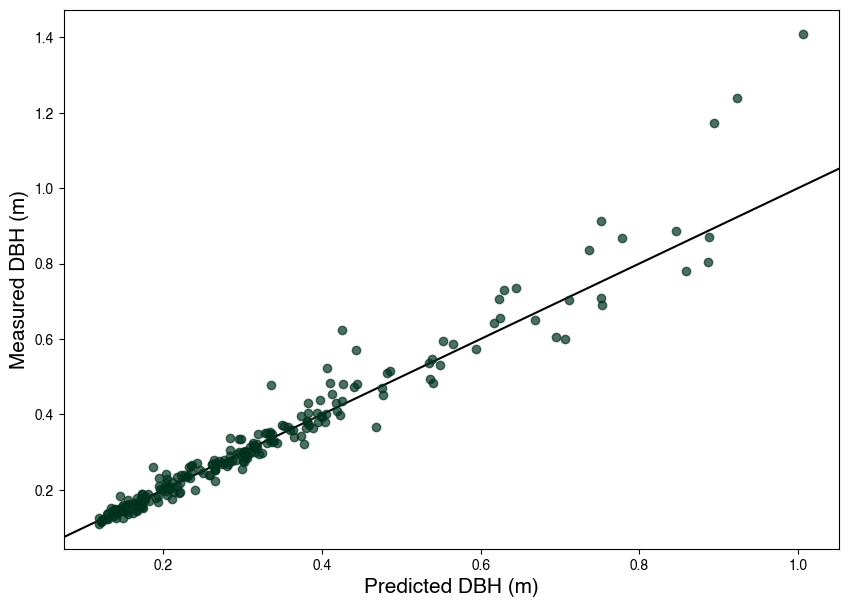

In [15]:
#rf_results = pd.DataFrame(mape, predictions, test_labels)
from sklearn.metrics import r2_score
wytham_rf_results = pd.DataFrame({'errors': wytham_random_errors, 'predictions': wytham_random_predictions, 'test_labels': w_test_labels}, columns=['mape', 'errors', 'predictions', 'test_labels'])

plt.figure(figsize=(10,7))
plt.axline((0.2, 0.2), slope=1, color = 'black', zorder = 1)
plt.scatter(wytham_rf_results['predictions'], wytham_rf_results['test_labels'], color='#013220', alpha=0.7, zorder=2)
plt.xlabel('Predicted DBH (m)', fontsize=15)
plt.ylabel('Measured DBH (m)', fontsize=15)

plt.annotate("r-squared = {:.3f}".format(r2_score(wytham_random_predictions, w_test_labels)), (0, 1))



Text(0, 0.5, 'Errors')

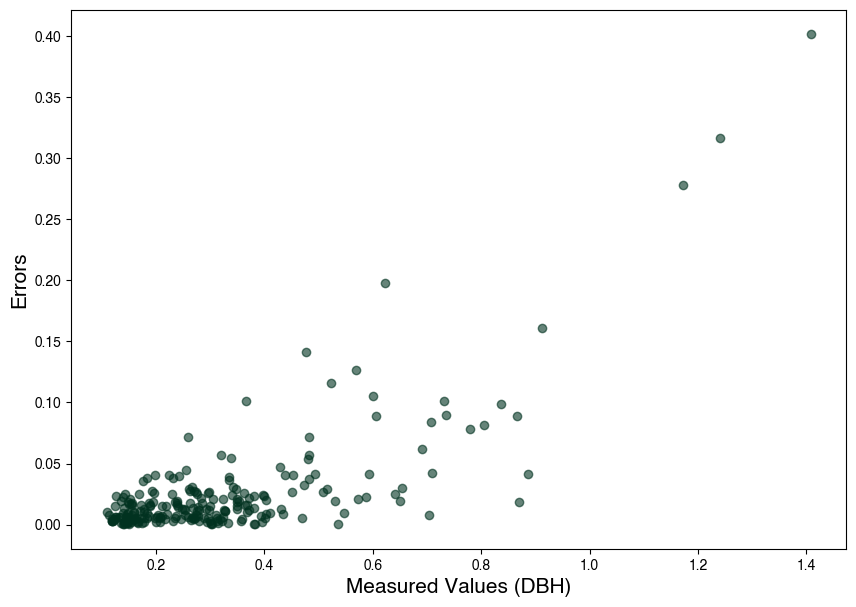

In [16]:
plt.figure(figsize=(10,7))
plt.scatter(wytham_rf_results['test_labels'], wytham_rf_results['errors'], color='#013220', alpha=0.6)
plt.xlabel('Measured Values (DBH)', fontsize=15)
plt.ylabel('Errors', fontsize=15)

Text(0, 0.5, 'Errors')

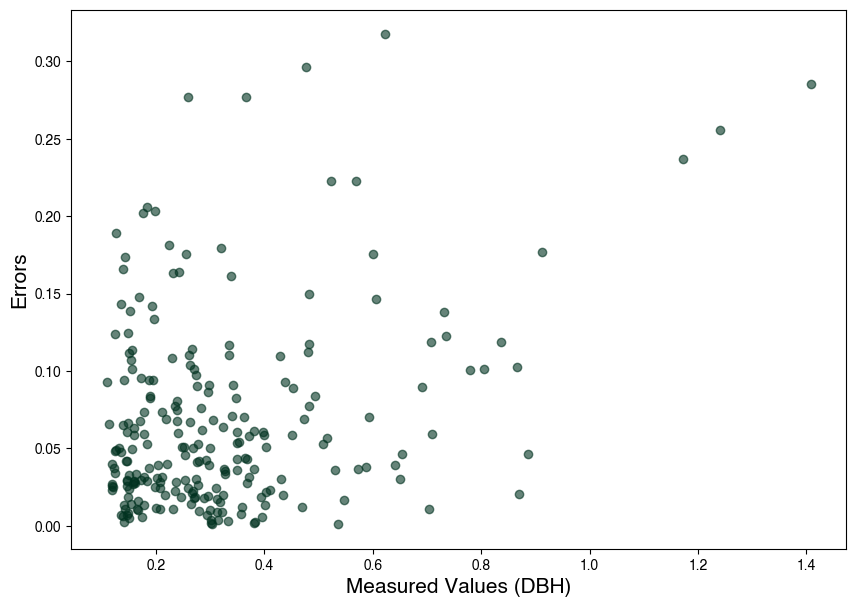

In [17]:
plt.figure(figsize=(10,7))
plt.scatter(wytham_rf_results['test_labels'], wytham_rf_results['errors'] / wytham_rf_results['test_labels'], color='#013220', alpha=0.6)
plt.xlabel('Measured Values (DBH)', fontsize=15)
plt.ylabel('Errors', fontsize=15)

## ALLOMETRY

To do allometry, first run the model on ALL the data so that we have predicted DBH for every tree. 

Text(0, 0.5, 'Measured DBH (m)')

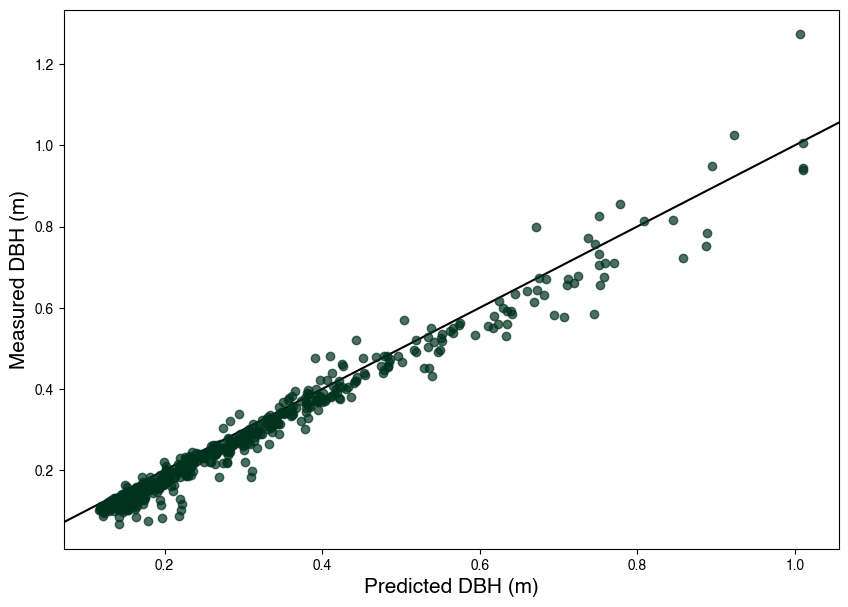

In [18]:
# test model on flagged data 
all_wytham_features = wytham.drop(['TLS_ID','dbhadj', 'dbh13', 'DBH_TLS_[m]', 'dbhcirc'], axis = 1)
all_wytham_featurelist = list(all_wytham_features.columns)
all_wytham_features = np.array(all_wytham_features)

# predict the flagged trees
all_wytham_predictions = wytham_best_random.predict(all_wytham_features)
wytham['predicteddbh'] = all_wytham_predictions

plt.figure(figsize=(10,7))
plt.axline((0.2, 0.2), slope=1, color = 'black', zorder = 1)
plt.scatter(wytham['predicteddbh'], wytham['DBH_TLS_[m]'], color='#013220', alpha=0.7, zorder=2)
plt.xlabel('Predicted DBH (m)', fontsize=15)
plt.ylabel('Measured DBH (m)', fontsize=15)

#plt.annotate("r-squared = {:.3f}".format(r2_score(wytham_random_predictions, w_test_labels)), (0, 1))

Text(0, 0.5, 'Measured DBH (m)')

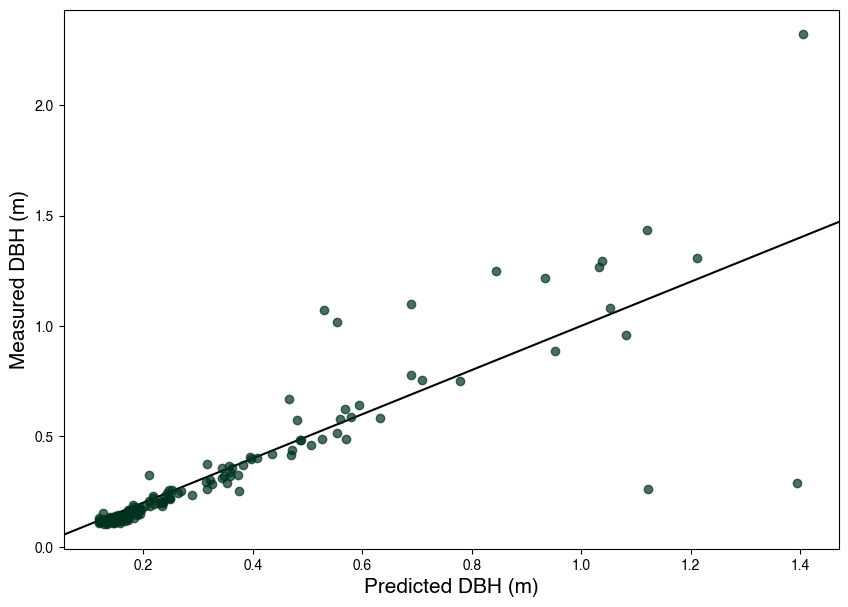

In [19]:
# test model on flagged data 
all_tropical_features = tropical.drop(['TLS_ID','dbhadj', 'dbh13', 'DBHqsm', 'DBHcyl', 'dbhcirc'], axis = 1)
all_tropical_featurelist = list(all_tropical_features.columns)
all_tropical_features = np.array(all_tropical_features)

# predict the flagged trees
all_tropical_predictions = tropical_best_random.predict(all_tropical_features)
tropical['predicteddbh'] = all_tropical_predictions

plt.figure(figsize=(10,7))
plt.axline((0.2, 0.2), slope=1, color = 'black', zorder = 1)
plt.scatter(tropical['predicteddbh'], tropical['DBHqsm'], color='#013220', alpha=0.7, zorder=2)
plt.xlabel('Predicted DBH (m)', fontsize=15)
plt.ylabel('Measured DBH (m)', fontsize=15)

#plt.annotate("r-squared = {:.3f}".format(r2_score(wytham_random_predictions, w_test_labels)), (0, 1))


In [20]:
%run '/Users/snix/Documents/2021-2023/UCL/Dissertation/CloudDBH/CloudDBH_Functions.ipynb'

In [21]:
wytham_results = wytham_allometry(wytham, 'allometry_hull', 'dbhadj')
wytham_results = wytham_allometry(wytham, 'allometry_circle', 'dbhcirc')
wytham_results = wytham_allometry(wytham, 'allometry_pred', 'predicteddbh')

# hull vs. tls
errors = abs(wytham_results['allometry_hull'] - wytham_results['Vol_QSM_avg_[m3]'])
mape = 100 * np.mean(errors / wytham_results['Vol_QSM_avg_[m3]'])
print(f'agreement - hull vs. tls: {100 - mape}')

# circle vs. tls
errors = abs(wytham_results['allometry_circle'] - wytham_results['Vol_QSM_avg_[m3]'])
mape = 100 * np.mean(errors / wytham_results['Vol_QSM_avg_[m3]'])
print(f'agreement - circle vs. tls: {100 - mape}')

# predicted vs. tls
errors = abs(wytham_results['allometry_pred'] - wytham_results['Vol_QSM_avg_[m3]'])
mape = 100 * np.mean(errors / wytham_results['Vol_QSM_avg_[m3]'])
print(f'agreement - predicted vs. tls: {100 - mape}')


hull_volume = np.sum(wytham_results[['allometry_hull']])
circ_volume = np.sum(wytham_results[['allometry_circle']])
pred_volume = np.sum(wytham_results[['allometry_pred']])
tls_volume = np.sum(wytham_results[['Vol_QSM_avg_[m3]']])

print(f'hull: {hull_volume}, circle: {circ_volume}, predicted: {pred_volume}, tls: {tls_volume}')

agreement - hull vs. tls: 57.45282384783929
agreement - circle vs. tls: 76.49463412751034
agreement - predicted vs. tls: 61.388233543628324
hull: allometry_hull    1179.166149
dtype: float64, circle: allometry_circle    949.436506
dtype: float64, predicted: allometry_pred    1102.870831
dtype: float64, tls: Vol_QSM_avg_[m3]    1014.11028
dtype: float64


In [22]:
tropical_results = trop_allometry(tropical, 'allometry_hull', 'dbhadj')
tropical_results = trop_allometry(tropical, 'allometry_circle', 'dbhcirc')
tropical_results = trop_allometry(tropical, 'allometry_pred', 'predicteddbh')

#tropical_results['TotalVolume_m3'] = tropical_results['TotalVolume_T']

# hull vs. tls
errors = abs(tropical_results['allometry_hull'] - tropical_results['TotalVolume_T'])
mape = 100 * np.mean(errors / tropical_results['TotalVolume_T'])

print(f'agreement - hull vs. tls: {100-mape}')

# circle vs. tls
errors = abs(tropical_results['allometry_circle'] - tropical_results['TotalVolume_T'])
mape = 100 * np.mean(errors / tropical_results['TotalVolume_T'])
print(f'agreement - circle vs. tls: {100-mape}')

# predicted vs. tls
errors = abs(tropical_results['allometry_pred'] - tropical_results['TotalVolume_T'])
mape = 100 * np.mean(errors / tropical_results['TotalVolume_T'])
print(f'agreement - predicted vs. tls: {100-mape}')


hull_volume = np.sum(tropical_results[['allometry_hull']])
circ_volume = np.sum(tropical_results[['allometry_circle']])
pred_volume = np.sum(tropical_results[['allometry_pred']])
tls_volume = np.sum(tropical_results[['TotalVolume_T']])

print(f'hull: {hull_volume}, circle: {circ_volume}, predicted: {pred_volume}, tls: {tls_volume}')

agreement - hull vs. tls: 59.915636283823055
agreement - circle vs. tls: 60.64799619381404
agreement - predicted vs. tls: 62.50531446258813
hull: allometry_hull    571.1825
dtype: float64, circle: allometry_circle    505.972161
dtype: float64, predicted: allometry_pred    552.270807
dtype: float64, tls: TotalVolume_T    548.12997
dtype: float64


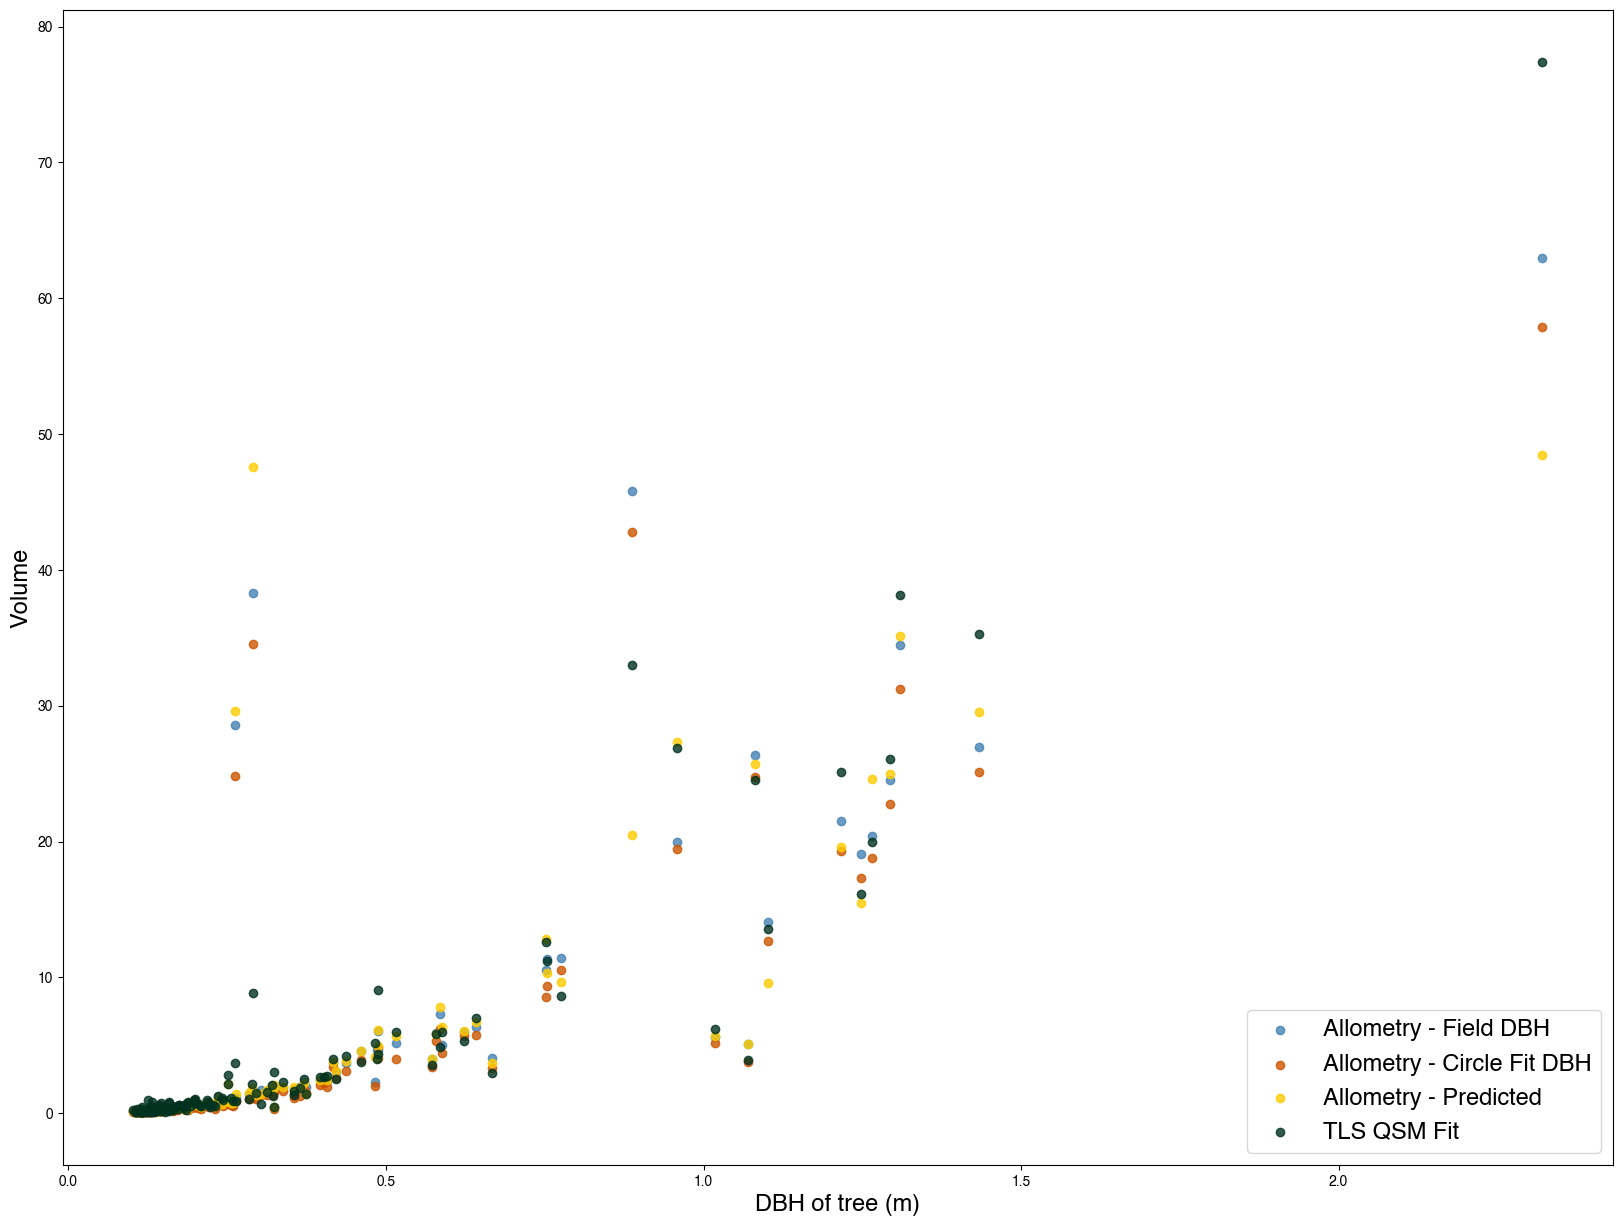

In [24]:
plt.figure(figsize=(20,15))


plt.scatter(tropical_results['DBHqsm'], tropical_results['allometry_hull'], label = 'Allometry - Field DBH', color='#4682B4', alpha=0.8)
plt.scatter(tropical_results['DBHqsm'], tropical_results['allometry_circle'], label = 'Allometry - Circle Fit DBH', color='#CC5500', alpha=0.8)
plt.scatter(tropical_results['DBHqsm'], tropical_results['allometry_pred'], label = 'Allometry - Predicted', color='#FFCC00', alpha=0.8)
plt.scatter(tropical_results['DBHqsm'], tropical_results['TotalVolume_T'], label = 'TLS QSM Fit', color='#013220', alpha=0.8)
plt.xlabel('DBH of tree (m)', fontsize=17)
plt.ylabel('Volume', fontsize=17)

plt.legend(loc="lower right", fontsize=17)

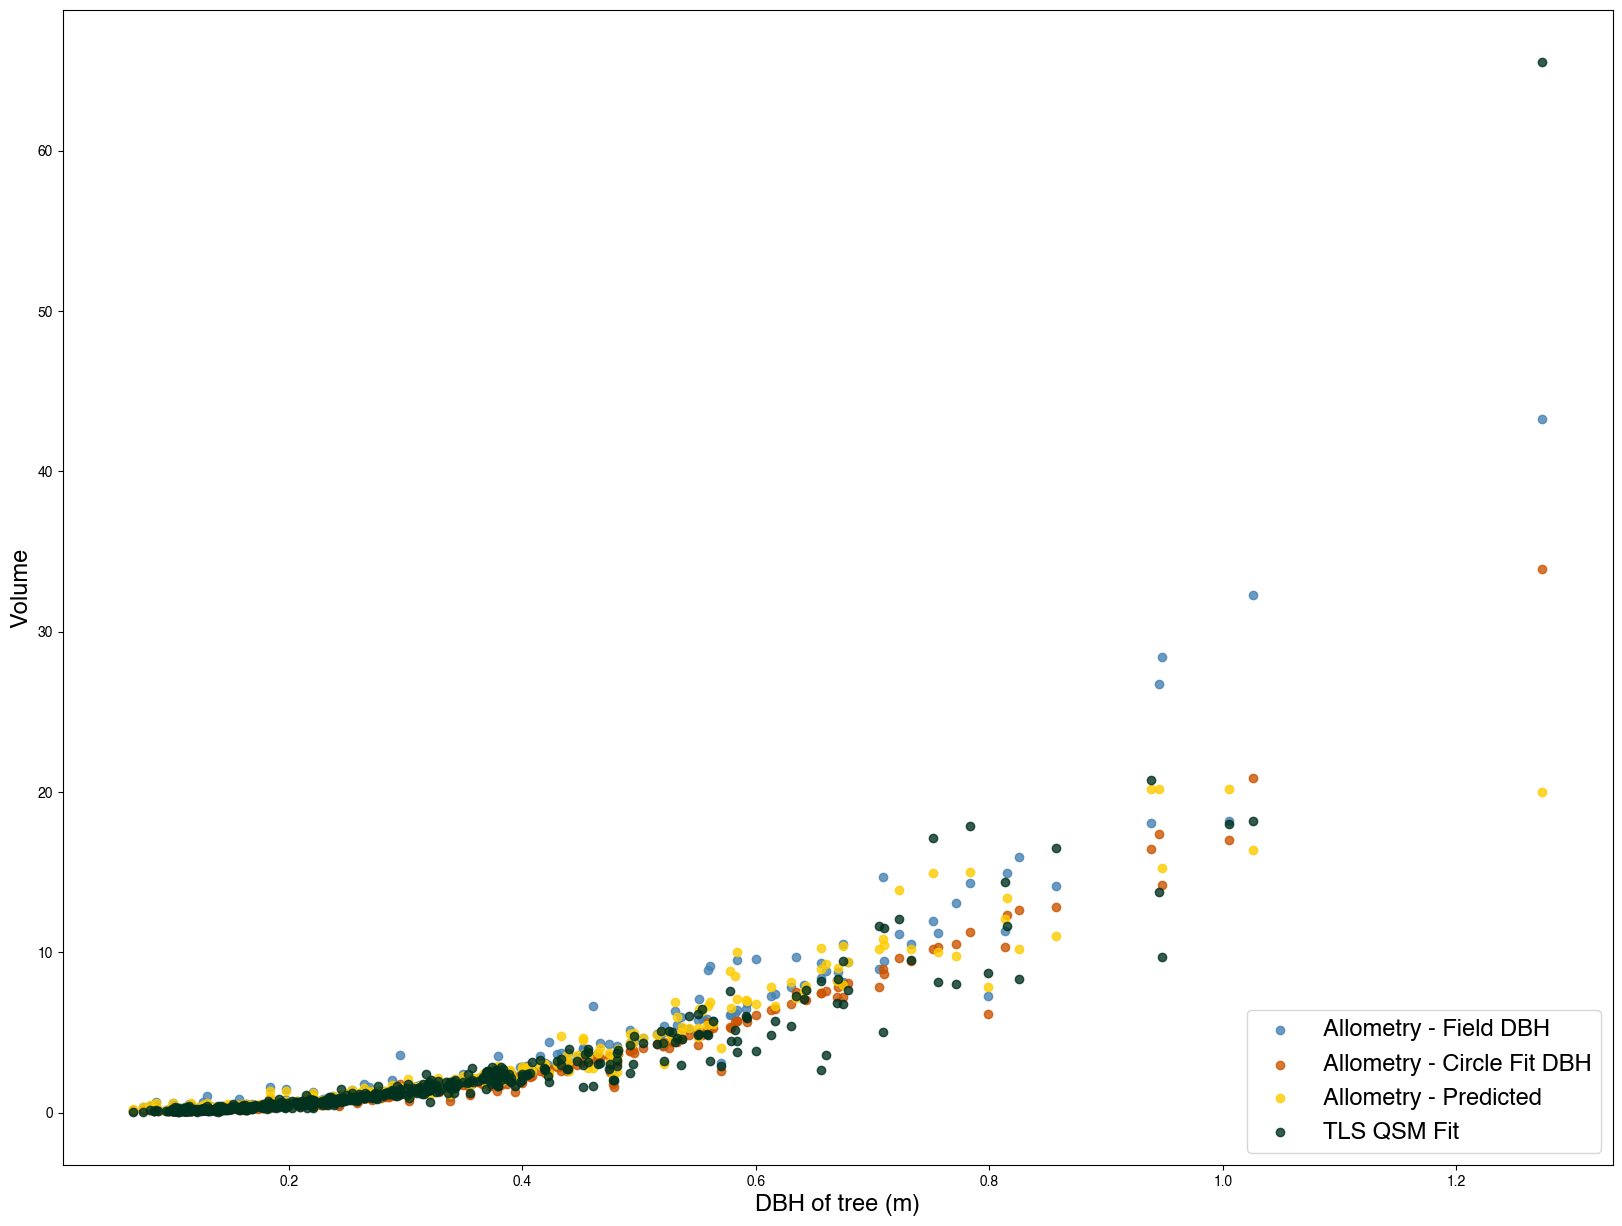

In [25]:
plt.figure(figsize=(20,15))


plt.scatter(wytham_results['DBH_TLS_[m]'], wytham_results['allometry_hull'], label = 'Allometry - Field DBH', color='#4682B4', alpha=0.8)
plt.scatter(wytham_results['DBH_TLS_[m]'], wytham_results['allometry_circle'], label = 'Allometry - Circle Fit DBH', color='#CC5500', alpha=0.8)
plt.scatter(wytham_results['DBH_TLS_[m]'], wytham_results['allometry_pred'], label = 'Allometry - Predicted', color='#FFCC00', alpha=0.8)
plt.scatter(wytham_results['DBH_TLS_[m]'], wytham_results['Vol_QSM_avg_[m3]'], label = 'TLS QSM Fit', color='#013220', alpha=0.8)
plt.xlabel('DBH of tree (m)', fontsize=17)
plt.ylabel('Volume', fontsize=17)

plt.legend(loc="lower right", fontsize=17)

Text(0, 0.5, 'DBH - Convex Hull (m)')

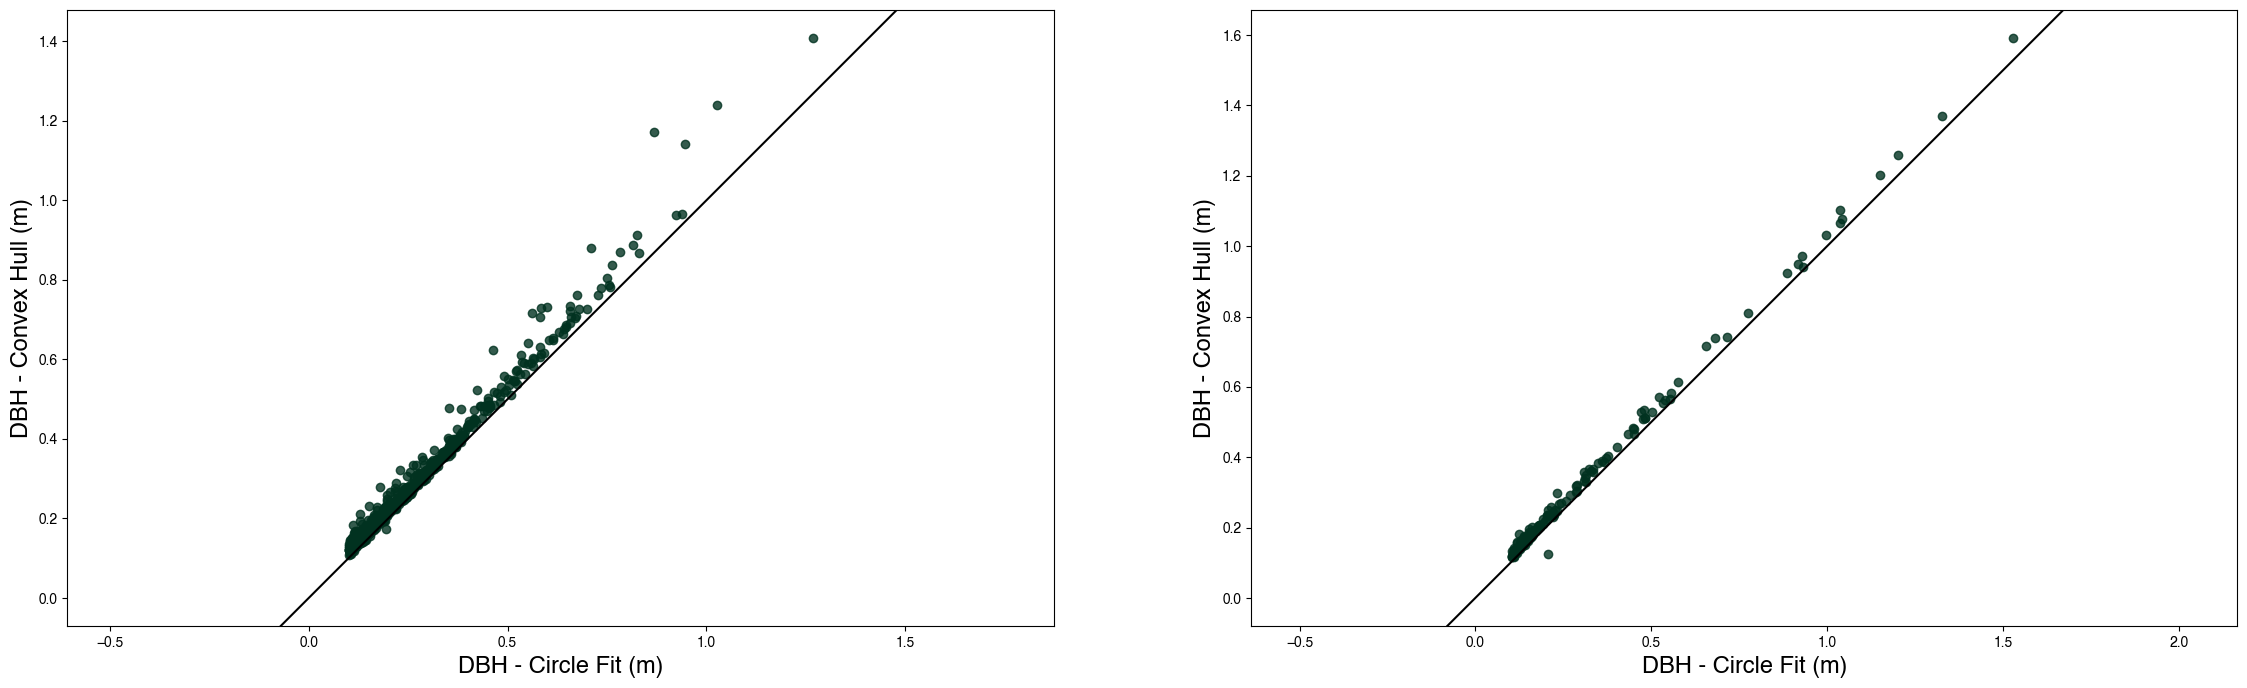

[CV] END bootstrap=True, max_depth=60, max_features=16, min_samples_leaf=1, min_samples_split=6, n_estimators=1600; total time=   1.1s
[CV] END bootstrap=True, max_depth=50, max_features=4, min_samples_leaf=1, min_samples_split=7, n_estimators=2000; total time=   1.1s
[CV] END bootstrap=False, max_depth=110, max_features=1, min_samples_leaf=5, min_samples_split=3, n_estimators=1200; total time=   0.5s
[CV] END bootstrap=False, max_depth=50, max_features=6, min_samples_leaf=5, min_samples_split=6, n_estimators=1600; total time=   0.7s
[CV] END bootstrap=False, max_depth=80, max_features=8, min_samples_leaf=3, min_samples_split=4, n_estimators=800; total time=   0.4s
[CV] END bootstrap=True, max_depth=30, max_features=6, min_samples_leaf=3, min_samples_split=8, n_estimators=600; total time=   0.3s
[CV] END bootstrap=False, max_depth=60, max_features=14, min_samples_leaf=5, min_samples_split=6, n_estimators=2000; total time=   1.1s
[CV] END bootstrap=False, max_depth=110, max_features=12,

[CV] END bootstrap=False, max_depth=110, max_features=10, min_samples_leaf=1, min_samples_split=5, n_estimators=1600; total time=   0.9s
[CV] END bootstrap=False, max_depth=20, max_features=12, min_samples_leaf=3, min_samples_split=8, n_estimators=400; total time=   0.2s
[CV] END bootstrap=True, max_depth=60, max_features=12, min_samples_leaf=4, min_samples_split=4, n_estimators=1600; total time=   1.0s
[CV] END bootstrap=False, max_depth=100, max_features=6, min_samples_leaf=5, min_samples_split=6, n_estimators=1600; total time=   0.7s
[CV] END bootstrap=False, max_depth=40, max_features=12, min_samples_leaf=3, min_samples_split=9, n_estimators=1000; total time=   0.5s
[CV] END bootstrap=True, max_depth=30, max_features=2, min_samples_leaf=1, min_samples_split=4, n_estimators=400; total time=   0.2s
[CV] END bootstrap=True, max_depth=100, max_features=6, min_samples_leaf=3, min_samples_split=8, n_estimators=1000; total time=   0.6s
[CV] END bootstrap=False, max_depth=40, max_features=

[CV] END bootstrap=True, max_depth=110, max_features=4, min_samples_leaf=3, min_samples_split=4, n_estimators=1400; total time=   0.8s
[CV] END bootstrap=False, max_depth=100, max_features=10, min_samples_leaf=1, min_samples_split=3, n_estimators=800; total time=   0.5s
[CV] END bootstrap=False, max_depth=70, max_features=4, min_samples_leaf=2, min_samples_split=9, n_estimators=2000; total time=   0.9s
[CV] END bootstrap=True, max_depth=60, max_features=14, min_samples_leaf=1, min_samples_split=10, n_estimators=800; total time=   0.5s
[CV] END bootstrap=True, max_depth=None, max_features=16, min_samples_leaf=5, min_samples_split=6, n_estimators=1200; total time=   0.7s
[CV] END bootstrap=True, max_depth=90, max_features=14, min_samples_leaf=5, min_samples_split=3, n_estimators=200; total time=   0.1s
[CV] END bootstrap=False, max_depth=110, max_features=12, min_samples_leaf=3, min_samples_split=10, n_estimators=1600; total time=   0.8s
[CV] END bootstrap=True, max_depth=50, max_feature

[CV] END bootstrap=False, max_depth=100, max_features=6, min_samples_leaf=5, min_samples_split=6, n_estimators=1600; total time=   0.7s
[CV] END bootstrap=False, max_depth=40, max_features=12, min_samples_leaf=3, min_samples_split=9, n_estimators=1000; total time=   0.5s
[CV] END bootstrap=True, max_depth=30, max_features=2, min_samples_leaf=1, min_samples_split=4, n_estimators=400; total time=   0.2s
[CV] END bootstrap=True, max_depth=100, max_features=6, min_samples_leaf=3, min_samples_split=8, n_estimators=1000; total time=   0.6s
[CV] END bootstrap=False, max_depth=40, max_features=2, min_samples_leaf=1, min_samples_split=4, n_estimators=1800; total time=   0.8s
[CV] END bootstrap=False, max_depth=50, max_features=12, min_samples_leaf=1, min_samples_split=8, n_estimators=800; total time=   0.4s
[CV] END bootstrap=True, max_depth=None, max_features=16, min_samples_leaf=1, min_samples_split=6, n_estimators=200; total time=   0.1s
[CV] END bootstrap=True, max_depth=20, max_features=4,

In [26]:
fig, axs = plt.subplots(1, 2, figsize = (28, 8))

axs[0].scatter(wytham['dbhcirc'], wytham['dbhadj'], color='#013220', alpha=0.8)
axs[0].axline((0, 0), slope=1, color = 'black')
axs[0].axis('equal')

axs[0].set_xlabel('DBH - Circle Fit (m)', fontsize=17)
axs[0].set_ylabel('DBH - Convex Hull (m)', fontsize=17)


axs[1].scatter(tropical['dbhcirc'], tropical['dbhadj'], color='#013220', alpha=0.8)
axs[1].axline((0, 0), slope=1, color = 'black')
axs[1].axis('equal')

axs[1].set_xlabel('DBH - Circle Fit (m)', fontsize=17)
axs[1].set_ylabel('DBH - Convex Hull (m)', fontsize=17)
